# NKDE results

In [13]:
import os
import glob
import pandas as pd
import geopandas as gpd

In [16]:

# ------------------ CONFIG ------------------
NKDE_DIR = "/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde"

LIXEL_FILES = {
    50:  "/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/roadnetwork/tha_highway_lixels_50m.gpkg",
    100: "/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/roadnetwork/tha_highway_lixels_100m.gpkg",
    200: "/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/roadnetwork/tha_highway_lixels_200m.gpkg",
    300: "/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/roadnetwork/tha_highway_lixels_300m.gpkg",
    500: "/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/roadnetwork/tha_highway_lixels_500m.gpkg",
}

LIXEL_LAYER_MAP = {50:"lixels_50m", 100:"lixels_100m", 200:"lixels_200m", 300:"lixels_300m", 500:"lixels_500m"}

SPACINGS = [50, 100, 200, 300, 500]
BWS      = [100, 200, 300]

OUT_DIR  = "/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined"
os.makedirs(OUT_DIR, exist_ok=True)

LIXEL_LAYER = "lixels_with_density"

In [18]:
# ------------------ HELPERS ------------------
def read_all_samples_for_combo(nkde_dir, spacing, bw):
    """Concat all per-province NKDE points for (spacing,bw)."""
    pat = os.path.join(nkde_dir, f"nkde_*_lx{spacing:03d}_bw{bw:03d}.gpkg")
    files = glob.glob(pat)
    if not files:
        print(f"[WARN] No NKDE files for lx={spacing}, bw={bw}  ({pat})")
        return gpd.GeoDataFrame(columns=["nkde_sample_id","density","geometry"], geometry="geometry", crs=None)

    gdfs = []
    for fp in files:
        try:
            g = gpd.read_file(fp, layer="nkde_density")
        except Exception as e:
            print(f"[WARN] Read fail {fp}: {e}")
            continue
        need = {"density", "geometry"}
        if not need.issubset(g.columns):
            print(f"[WARN] {os.path.basename(fp)} missing {need - set(g.columns)}; skip")
            continue
        # keep id if present (for ID-join attempt)
        keep_cols = ["density", "geometry"] + (["nkde_sample_id"] if "nkde_sample_id" in g.columns else [])
        g = g[keep_cols].copy()
        gdfs.append(g)
    if not gdfs:
        return gpd.GeoDataFrame(columns=["nkde_sample_id","density","geometry"], geometry="geometry", crs=None)

    big = pd.concat(gdfs, ignore_index=True)
    big = gpd.GeoDataFrame(big, geometry="geometry", crs=gdfs[0].crs)
    return big

def normalize_id_series(s):
    """Make IDs comparable: cast to str and keep only digits if mixed formats."""
    s = s.astype(str).str.strip()
    # If formats differ (e.g., "lx50_12345"), extract trailing digits
    # but only if that increases intersection later (we’ll just standardize here).
    s_num = s.str.extract(r"(\d+)$", expand=False)
    # Prefer numeric tail if it exists for most rows; else keep full string.
    if s_num.notna().mean() > 0.8:
        return s_num.fillna(s)
    return s

def try_id_join(lixels, pts_df, bw):
    """Attempt ID-based join. Returns (joined_gdf, match_ratio)."""
    if "nkde_sample_id" not in lixels.columns or "nkde_sample_id" not in pts_df.columns:
        return None, 0.0
    L = lixels.copy()
    P = pts_df.copy()
    L["nkde_sample_id"] = normalize_id_series(L["nkde_sample_id"])
    P["nkde_sample_id"] = normalize_id_series(P["nkde_sample_id"])

    before = len(L)
    # Collapse duplicates on point side (mean density if multiple)
    P = P.groupby("nkde_sample_id", as_index=False)["density"].mean()
    # Merge
    col = f"density_bw{bw}"
    joined = L.merge(P, on="nkde_sample_id", how="left")
    matched = joined["density"].notna().sum()
    ratio = matched / before if before else 0.0
    joined[col] = joined["density"].fillna(0.0)
    joined.drop(columns=["density"], inplace=True)
    return joined, ratio

def spatial_join_to_lixels(lixels, pts_gdf, bw, agg="mean", max_dist=3.0):
    """
    Spatially attach point densities to lixels.
    - snaps via sjoin_nearest with a small max_dist (metres)
    - aggregates to one value per lixel (mean|max)
    """
    col = f"density_bw{bw}"
    out = lixels.copy()

    if pts_gdf.empty:
        out[col] = 0.0
        return out

    # Ensure same CRS
    if out.crs != pts_gdf.crs:
        pts_gdf = pts_gdf.to_crs(out.crs)

    # nearest join (points -> lines)
    joined = gpd.sjoin_nearest(
        pts_gdf[["density","geometry"]],
        out[["geometry"]], how="left", max_distance=max_dist, distance_col=None
    )
    # joined has index_right = lixel row index
    joined = joined.reset_index().rename(columns={"index_right":"lix_idx"})
    # Drop points that did not match (NaN lix_idx)
    joined = joined[joined["lix_idx"].notna()]
    if joined.empty:
        out[col] = 0.0
        return out

    # Aggregate per lixel
    if agg == "max":
        agg_series = joined.groupby("lix_idx")["density"].max()
    else:
        agg_series = joined.groupby("lix_idx")["density"].mean()

    out[col] = 0.0
    # align by integer index
    ix = agg_series.index.astype(int)
    out.loc[ix, col] = agg_series.values
    return out

# ------------------ MAIN ------------------
for lx in SPACINGS:
    lix_path = LIXEL_FILES.get(lx)
    layer    = LIXEL_LAYER_MAP.get(lx)
    if not lix_path or not os.path.exists(lix_path):
        print(f"[WARN] Lixel file not found for lx={lx}: {lix_path}")
        continue

    try:
        lixels = gpd.read_file(lix_path, layer=layer)
    except Exception as e:
        print(f"[WARN] Failed to read {lix_path} (layer={layer}): {e}")
        continue

    # Prepare working copy
    lixels_out = lixels.copy()

    for bw in BWS:
        print(f"[INFO] lx={lx}, bw={bw} …")
        pts = read_all_samples_for_combo(NKDE_DIR, spacing=lx, bw=bw)
        # format pts["nkde_sample_id"] to be the same type as lixels["nkde_sample_id"] (string or int)
        if "nkde_sample_id" in lixels_out.columns and "nkde_sample_id" in pts.columns:
            pts["nkde_sample_id"] = pts["nkde_sample_id"].astype(lixels_out["nkde_sample_id"].dtype)

        # 1) Try ID join (fast)
        by_id, ratio = try_id_join(lixels_out, pts, bw)
        if by_id is not None and ratio >= 0.01:   # >=1% matched → accept ID join
            print(f"     ID-join matched {ratio:.1%} of lixels → using ID join.")
            lixels_out = by_id
            continue
        else:
            print(f"     ID-join matched {0 if by_id is None else ratio:.1%} → falling back to spatial join.")

        # 2) Spatial join fallback (robust)
        lixels_out = spatial_join_to_lixels(lixels_out, pts, bw, agg="mean", max_dist=3.0)

    out_path = os.path.join(OUT_DIR, f"lixels_with_density_lx{lx:03d}.gpkg")
    # lixels_out.to_file(out_path, layer="lixels_with_density", driver="GPKG")
    print(f"[OK] Saved: {out_path}")


[INFO] lx=50, bw=100 …
     ID-join matched 99.5% of lixels → using ID join.
[INFO] lx=50, bw=200 …
     ID-join matched 0.0% → falling back to spatial join.
[INFO] lx=50, bw=300 …
     ID-join matched 0.0% → falling back to spatial join.
[OK] Saved: /Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/lixels_with_density_lx050.gpkg
[INFO] lx=100, bw=100 …
     ID-join matched 99.5% of lixels → using ID join.
[INFO] lx=100, bw=200 …
     ID-join matched 0.0% → falling back to spatial join.
[INFO] lx=100, bw=300 …
     ID-join matched 0.0% → falling back to spatial join.
[OK] Saved: /Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/lixels_with_density_lx100.gpkg
[INFO] lx=200, bw=100 …
     ID-join matched 99.5% of lixels → using ID join.
[INFO] lx=200, bw=200 …
     ID-join matched 0.0% → falling back to spatial join.
[INFO] lx=200, bw=300 …

In [ ]:
# # read all lixels_with_desity files
# lixels_50 = gpd.read_file('/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/lixels_with_density_lx050.gpkg')
# lixels_100 = gpd.read_file('/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/lixels_with_density_lx100.gpkg')
# lixels_200 = gpd.read_file('/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/lixels_with_density_lx200.gpkg')
# lixels_300 = gpd.read_file('/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/lixels_with_density_lx300.gpkg')
# lixels_500 = gpd.read_file('/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/lixels_with_density_lx500.gpkg')

### Evaluation Metrics

**Hit Rate (HR)**  
We measure how well NKDE hotspots capture motorcycle crashes. Each crash \(i\) is assigned a severity-based weight:

\[
w_i = 6 \times \text{Fatalities} + 4 \times \text{Serious Injuries} + 2 \times \text{Minor Injuries},
\]

with a minimum of \(w_i=1\) for crashes without casualties.

Lixels are ranked by density, and the top \(p\%\) of network length is selected. Crashes are snapped to their nearest lixel within **25 m**. The weighted hit rate is:

\[
\mathrm{HR}_w(p) = \frac{\sum_{i:\,\text{lixel}(i) \in \mathcal{S}_p} w_i}{\sum_i w_i},
\]

where \(\mathcal{S}_p\) is the set of top-\(p\%\) lixels.  
For comparison, we also report the unweighted version:

\[
\mathrm{HR}(p) = \frac{\#\{\text{crashes in } \mathcal{S}_p\}}{\#\{\text{all crashes}\}}.
\]

---

**Prediction Accuracy Index (PAI)**  
The PAI compares hotspot concentration against random allocation:

\[
\mathrm{PAI}_w(p) = \frac{\mathrm{HR}_w(p)}{p}.
\]

Values \(>1\) mean the model concentrates crashes more effectively than random selection.

---

**Snapping tolerance**  
Crash points are linked to the nearest lixel within **25 m**. This fixed tolerance balances accuracy (avoiding mismatches far from the road) and efficiency. Using a nearest-neighbour spatial join is also faster than buffering every lixel.


In [ ]:
# # import accidents > "DOH/motorcycle_accidents_TRAMS.shp"
# accidents = gpd.read_file("DOH/motorcycle_accidents_TRAMS.shp")

# # create weight column
# accidents["weight"] = 6* accidents['Fatalities'] + 4* accidents['SeriousInj'] + 2 * accidents['MinorInjur']
# accidents["weight"] = accidents["weight"].replace(0, 1)

In [19]:
import os
import pandas as pd
import geopandas as gpd

# ---------------- config ----------------
SPACINGS   = [50, 100, 200, 300, 500]
BWS        = [100, 200, 300]
SNAP_TOL   = 25  # metres
LIXEL_JOINED_DIR = "/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined"

# Read lixels with NKDE densities (one file per spacing)
LIXEL_FILES = {
    50:  f"{LIXEL_JOINED_DIR}/lixels_with_density_lx050.gpkg",
    100: f"{LIXEL_JOINED_DIR}/lixels_with_density_lx100.gpkg",
    200: f"{LIXEL_JOINED_DIR}/lixels_with_density_lx200.gpkg",
    300: f"{LIXEL_JOINED_DIR}/lixels_with_density_lx300.gpkg",
    500: f"{LIXEL_JOINED_DIR}/lixels_with_density_lx500.gpkg",
}
LIXEL_LAYER = "lixels_with_density"

# Read accidents and build weights
accidents = gpd.read_file("DOH/motorcycle_accidents_TRAMS.shp")
accidents["weight"] = (
    6*accidents.get("Fatalities", 0).fillna(0) +
    4*accidents.get("SeriousInj", 0).fillna(0) +
    2*accidents.get("MinorInjur", 0).fillna(0)
).astype(float)
# If weight == 0 or NA, set to 1 so every crash counts at least a little
accidents.loc[~accidents["weight"].replace([float("inf"), -float("inf")], pd.NA).notna() | (accidents["weight"] <= 0), "weight"] = 1.0

# -------------- helpers --------------
def snap_points_to_lixels(points_gdf, lixels_gdf, max_dist=25):
    """
    Assign each point to the nearest lixel within max_dist (metres).
    Returns a copy with a 'lixel_idx' column (integer row index of lixels_gdf).
    """
    pts = points_gdf.copy()
    if pts.crs != lixels_gdf.crs:
        pts = pts.to_crs(lixels_gdf.crs)

    # fast nearest join (vectorised)
    nearest = gpd.sjoin_nearest(
        pts[["weight", "geometry"]],
        lixels_gdf[["geometry"]],
        how="left",
        max_distance=max_dist,
        distance_col="dist"
    )
    # keep only matches within tolerance
    nearest = nearest[nearest["dist"].notna()].copy()
    # index_right is the matched lixel's index
    nearest = nearest.rename(columns={"index_right": "lixel_idx"})
    nearest["lixel_idx"] = nearest["lixel_idx"].astype(int)
    return nearest[["weight", "geometry", "lixel_idx"]]

def evaluate_hr_pai(lixels_gdf, snapped_pts, density_col, coverages=(0.001,0.01, 0.05)):
    """
    Compute weighted & unweighted HR and PAI for given density column and coverage levels.
    - lixels_gdf: GeoDataFrame with 'geometry' and the density_col
    - snapped_pts: DataFrame with columns ['weight','lixel_idx'] (output of snap_points_to_lixels)
    """
    if lixels_gdf.crs is None or lixels_gdf.crs.is_geographic:
        raise ValueError("Lixels CRS must be projected in metres for length calculations.")

    # Compute lixel lengths and rank by density
    lx = lixels_gdf.copy()
    lx["len_m"] = lx.geometry.length
    total_len = float(lx["len_m"].sum())

    lx = lx.sort_values(density_col, ascending=False).copy()
    lx["cum_len"] = lx["len_m"].cumsum()

    # Precompute totals for weighting
    total_crashes = len(snapped_pts)
    total_weight  = float(snapped_pts["weight"].sum()) if total_crashes > 0 else 0.0

    rows = []
    for cov in coverages:
        cutoff = cov * total_len
        top_idx = set(lx.loc[lx["cum_len"] <= cutoff].index)

        # Unweighted hits
        hits_unw = snapped_pts["lixel_idx"].isin(top_idx).sum()
        hr_unw   = (hits_unw / total_crashes) if total_crashes > 0 else 0.0
        pai_unw  = (hr_unw / cov) if cov > 0 else None

        # Weighted hits
        w_hits = float(snapped_pts.loc[snapped_pts["lixel_idx"].isin(top_idx), "weight"].sum())
        hr_w   = (w_hits / total_weight) if total_weight > 0 else 0.0
        pai_w  = (hr_w / cov) if cov > 0 else None

        rows.append({
            "coverage_%": int(cov * 100),
            "HR_%_unweighted": hr_unw * 100.0,
            "PAI_unweighted":  pai_unw,
            "HR_%_weighted":   hr_w  * 100.0,
            "PAI_weighted":    pai_w
        })
    return pd.DataFrame(rows)

# -------------- main --------------
all_results = []

for lx in SPACINGS:
    lx_path = LIXEL_FILES[lx]
    if not os.path.exists(lx_path):
        print(f"[WARN] missing lixels for {lx}m: {lx_path}")
        continue

    lixels = gpd.read_file(lx_path, layer=LIXEL_LAYER)

    # Snap accidents once per spacing
    snapped = snap_points_to_lixels(accidents, lixels, max_dist=SNAP_TOL)

    for bw in BWS:
        dens_col = f"density_bw{bw}"
        if dens_col not in lixels.columns:
            print(f"[WARN] {dens_col} missing in {os.path.basename(lx_path)}; skipping.")
            continue

        res = evaluate_hr_pai(lixels, snapped, density_col=dens_col, coverages=( 0.001, 0.01, 0.05))
        res.insert(0, "bw_m", bw)
        res.insert(0, "lixel_m", lx)
        all_results.append(res)

results_df = pd.concat(all_results, ignore_index=True)
results_df.round({"HR_%_unweighted": 1, "PAI_unweighted": 2, "HR_%_weighted": 1, "PAI_weighted": 2})


lixel_m  bw_m  coverage_%  HR_%_unweighted  PAI_unweighted  HR_%_weighted  \
0        50   100           0             10.0           99.60           18.8   
1        50   100           1             56.6           56.62           75.6   
2        50   100           5             97.3           19.46           97.3   
3        50   200           0              7.2           72.48           11.8   
4        50   200           1             38.6           38.61           52.8   
5        50   200           5             96.1           19.22           97.0   
6        50   300           0              6.4           63.52            9.0   
7        50   300           1             32.6           32.55           44.6   
8        50   300           5             81.6           16.31           90.9   
9       100   100           0              8.3           82.75           15.4   
10      100   100           1             51.7           51.74           70.3   
11      100   100           5             97.2           19.44           97.2   
12      100   200           0              7.1           70.57           11.3   
13      100   200           1             38.0           38.04           52.2   
14      100   200           5             95.7           19.13           96.9   
15      100   300           0              6.2           62.09            8.8   
16      100   300           1             32.2           32.21           44.3   
17      100   300           5             81.3           16.25           90.8   
18      200   100           0              5.4           54.21            9.2   
19      200   100           1             34.7           34.74           45.5   
20      200   100           5             94.3           18.86           94.2   
21      200   200           0              6.1           61.26            9.4   
22      200   200           1             34.4           34.42           47.6   
23      200   200           5             95.1           19.02           96.7   
24      200   300           0              5.7           57.09            8.0   
25      200   300           1             30.9           30.89           42.3   
26      200   300           5             80.9           16.18           90.6   
27      300   100           0              4.2           41.74            6.8   
28      300   100           1             26.8           26.83           33.4   
29      300   100           5             72.6           14.51           70.6   
30      300   200           0              5.3           53.06            7.6   
31      300   200           1             29.1           29.07           38.6   
32      300   200           5             89.6           17.93           93.1   
33      300   300           0              5.6           55.63            7.3   
34      300   300           1             28.3           28.34           38.1   
35      300   300           5             79.7           15.93           89.6   
36      500   100           0              3.5           35.42            5.1   
37      500   100           1             20.9           20.94           24.3   
38      500   100           5             55.8           11.16           52.4   
39      500   200           0              4.4           43.83            5.7   
40      500   200           1             23.1           23.10           28.1   
41      500   200           5             69.4           13.88           69.9   
42      500   300           0              4.8           48.34            5.7   
43      500   300           1             24.1           24.06           29.9   
44      500   300           5             68.8           13.76           77.0   

    PAI_weighted  
0         187.80  
1          75.62  
2          19.46  
3         117.63  
4          52.81  
5          19.41  
6          89.62  
7          44.65  
8          18.19  
9         154.24  
10         70.32  
11         19.44  
12        112.89  
13         

In [20]:
print(results_df)

    lixel_m  bw_m  coverage_%  HR_%_unweighted  PAI_unweighted  HR_%_weighted  \
0        50   100           0         9.959717       99.597166      18.779723   
1        50   100           1        56.618975       56.618975      75.620210   
2        50   100           5        97.287818       19.457564      97.288190   
3        50   200           0         7.247534       72.475344      11.762790   
4        50   200           1        38.606056       38.606056      52.805713   
5        50   200           5        96.082789       19.216558      97.045861   
6        50   300           0         6.351577       63.515766       8.962378   
7        50   300           1        32.553132       32.553132      44.646806   
8        50   300           5        81.556466       16.311293      90.938418   
9       100   100           0         8.275455       82.754549      15.424227   
10      100   100           1        51.736352       51.736352      70.320783   
11      100   100           

<Axes: ylabel='Frequency'>

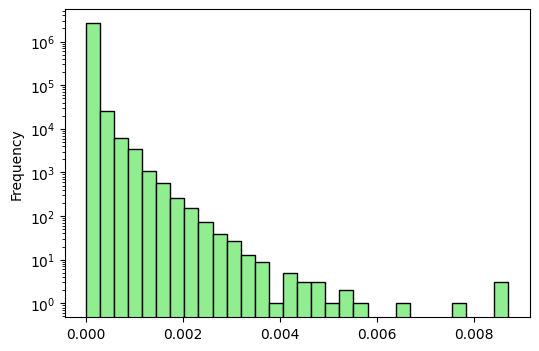

In [45]:
# plot lixels_50['density_bw100'] histogram
# lixels_50 = gpd.read_file('/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/lixels_with_density_lx050.gpkg')
plt.figure(figsize=(6,4))
lixels_50['density_bw100'].plot(
    kind="hist",
    bins=30,
    color="lightgreen",
    edgecolor="black",
    log=True
)

### AULC

In [26]:
def hr_pai_at_p(lixels_gdf, snapped_pts, dens_col, p=0.01):
    """
    Deterministic HR/PAI at coverage p for lixel-based NKDE.
    - Recomputes len_m in the current CRS (must be metric)
    - No index reset (snapped lixel_idx stays valid)
    - Coverage selection on the whole network (zeros included)
    - Under-shoot rule: include lixels while cum_len <= cutoff
    """
    L = lixels_gdf.copy()
    if L.crs is None or L.crs.is_geographic:
        raise ValueError("Lixels CRS must be projected in metres.")
    # Force length recompute (don’t trust any pre-existing column)
    L["len_m"] = L.geometry.length

    # Rank by density (desc), compute cumulative length
    order = L[dens_col].fillna(-np.inf).argsort()[::-1]
    L = L.iloc[order].copy()
    L["cum_len"] = L["len_m"].cumsum()
    cutoff = p * float(L["len_m"].sum())
    top_idx = set(L.index[L["cum_len"] <= cutoff])  # under-shoot

    # Hits
    s = snapped_pts  # assume lixel_idx refers to original indices
    total_unw = len(s)
    total_w   = float(s["weight"].sum())
    m = s["lixel_idx"].isin(top_idx)

    HR_unw = (m.sum() / total_unw) if total_unw > 0 else 0.0
    HR_w   = (float(s.loc[m, "weight"].sum()) / total_w) if total_w > 0 else 0.0
    return {
        "HR_unw": HR_unw, "PAI_unw": HR_unw / p if p > 0 else None,
        "HR_w":   HR_w,   "PAI_w":   HR_w   / p if p > 0 else None
    }


In [27]:
def hr_curve_lixel(lixels_gdf, snapped_pts, bw_col, p_grid=None):
    L = lixels_gdf.copy()
    if L.crs is None or L.crs.is_geographic:
        raise ValueError("Lixels CRS must be projected in metres.")
    # OVERWRITE any cached lengths
    L["len_m"] = L.geometry.length

    vals = L[bw_col].to_numpy()
    order = np.argsort(np.nan_to_num(vals, nan=-np.inf))[::-1]
    ordered_idx = L.index.values[order]

    cum_len = L.loc[ordered_idx, "len_m"].cumsum().to_numpy()
    total_len = float(L["len_m"].sum())

    if p_grid is None:
        p_grid = np.unique(np.r_[0.001, 0.01, 0.05, np.linspace(0.001, 0.20, 200)])

    s = snapped_pts.copy()
    total_unw = float(len(s))
    total_w   = float(s["weight"].sum()) if total_unw > 0 else 0.0

    out = []
    for p in p_grid:
        k = int(np.searchsorted(cum_len, p * total_len, side="right"))  # under-shoot
        picked = set(ordered_idx[:k])
        m = s["lixel_idx"].isin(picked)
        H_u = (m.sum() / total_unw) if total_unw > 0 else 0.0
        H_w = (s.loc[m, "weight"].sum() / total_w) if total_w > 0 else 0.0
        out.append((p, H_u, H_w, H_u/p, H_w/p))
    return pd.DataFrame(out, columns=["p","HR_unw","HR_w","PAI_unw","PAI_w"])


In [28]:
# pick 100 m / 200 m
lixels = gpd.read_file(LIXEL_FILES[100], layer=LIXEL_LAYER)
snapped = snap_points_to_lixels(accidents, lixels, max_dist=SNAP_TOL)

one_point = hr_pai_at_p(lixels, snapped, "density_bw200", p=0.01)
curve = hr_curve_lixel(lixels, snapped, "density_bw200")
at_1 = curve.loc[(curve["p"]-0.01).abs().idxmin()]

print("HR@1% (definitive):", one_point["HR_w"]*100, "PAI@1%:", one_point["PAI_w"])
print("HR@1% (curve):     ", at_1["HR_w"]*100,       "PAI@1%:", at_1["PAI_w"])


HR@1% (definitive): 52.20292006179383 PAI@1%: 52.20292006179383
HR@1% (curve):      52.20292006179383 PAI@1%: 52.20292006179383


In [31]:
import os, re, numpy as np, pandas as pd, geopandas as gpd

# ---------- canonical helpers (metric CRS, full network, under-shoot) ----------
def hr_curve_lixel(lixels_gdf, snapped_pts, bw_col, p_grid=None):
    L = lixels_gdf.copy()
    if L.crs is None or L.crs.is_geographic:
        raise ValueError("Lixels CRS must be projected in metres.")
    L["len_m"] = L.geometry.length

    vals = L[bw_col].to_numpy()
    order = np.argsort(np.nan_to_num(vals, nan=-np.inf))[::-1]
    ordered_idx = L.index.values[order]
    cum_len = L.loc[ordered_idx, "len_m"].cumsum().to_numpy()
    total_len = float(L["len_m"].sum())

    if p_grid is None:
        p_grid = np.unique(np.r_[0.001, 0.01, 0.05, np.linspace(0.001, 0.20, 200)])

    s = snapped_pts
    total_unw = float(len(s))
    total_w   = float(s["weight"].sum()) if total_unw > 0 else 0.0

    out = []
    for p in p_grid:
        k = int(np.searchsorted(cum_len, p * total_len, side="right"))  # <= cutoff (under-shoot)
        picked = set(ordered_idx[:k])
        m = s["lixel_idx"].isin(picked)
        H_u = (m.sum() / total_unw) if total_unw > 0 else 0.0
        H_w = (s.loc[m, "weight"].sum() / total_w) if total_w > 0 else 0.0
        out.append((p, H_u, H_w, H_u/p, H_w/p))
    return pd.DataFrame(out, columns=["p","HR_unw","HR_w","PAI_unw","PAI_w"])

def aulc(df, pmax=0.01, weighted=True):
    col = "PAI_w" if weighted else "PAI_unw"
    d = df[df["p"] <= pmax]
    return float(np.trapz(d[col].to_numpy(), d["p"].to_numpy()))

def metrics_at_p(df, p=0.01, weighted=True):
    i = (df["p"]-p).abs().idxmin()
    if weighted:
        return {"HR_w": float(df.loc[i,"HR_w"]), "PAI_w": float(df.loc[i,"PAI_w"])}
    else:
        return {"HR_unw": float(df.loc[i,"HR_unw"]), "PAI_unw": float(df.loc[i,"PAI_unw"])}

# ---------- recompute 1% summary across all lixel × bandwidth ----------
rows = []
for lx in SPACINGS:
    path = LIXEL_FILES.get(lx)
    if not path or not os.path.exists(path):
        print(f"[WARN] missing lixels for {lx}m: {path}")
        continue

    L = gpd.read_file(path, layer=LIXEL_LAYER)          # keep original index
    snapped = snap_points_to_lixels(accidents, L, max_dist=SNAP_TOL)

    dens_cols = sorted([c for c in L.columns if c.startswith("density_bw")],
                       key=lambda c: int(re.findall(r"\d+", c)[0]))
    for c in dens_cols:
        bw = int(re.findall(r"\d+", c)[0])
        curve = hr_curve_lixel(L, snapped, c)
        a1  = aulc(curve, 0.01, weighted=True)
        m1w = metrics_at_p(curve, p=0.01, weighted=True)
        m1u = metrics_at_p(curve, p=0.01, weighted=False)
        rows.append({
            "lixel_m": lx, "bw_m": bw,
            "AULC_1": a1, "AvgPAI_1": a1/0.01,
            "HR1_w_%": m1w["HR_w"]*100, "PAI1_w": m1w["PAI_w"],
            "HR1_unw_%": m1u["HR_unw"]*100, "PAI1_unw": m1u["PAI_unw"],
        })

summary1 = pd.DataFrame(rows).sort_values(["lixel_m","bw_m"]).reset_index(drop=True)

print(summary1)


    lixel_m  bw_m    AULC_1    AvgPAI_1    HR1_w_%     PAI1_w  HR1_unw_%  \
0        50   100  1.013625  101.362487  75.620210  75.620210  56.618975   
1        50   200  0.687501   68.750122  52.805713  52.805713  38.606056   
2        50   300  0.537573   53.757299  44.646806  44.646806  32.553132   
3       100   100  0.863922   86.392183  70.320783  70.320783  51.736352   
4       100   200  0.654793   65.479313  52.202920  52.202920  38.040006   
5       100   300  0.526407   52.640650  44.287099  44.287099  32.212807   
6       200   100  0.538559   53.855915  45.509345  45.509345  34.737464   
7       200   200  0.564609   56.460945  47.640324  47.640324  34.417975   
8       200   300  0.488656   48.865600  42.340139  42.340139  30.886234   
9       300   100  0.394748   39.474829  33.441372  33.441372  26.830115   
10      300   200  0.446769   44.676854  38.572683  38.572683  29.066537   
11      300   300  0.437474   43.747363  38.143307  38.143307  28.340742   
12      500 

In [ ]:
# import numpy as np
# import pandas as pd
# import geopandas as gpd

# def hr_curve_lixel(lixels_gdf, snapped_pts, bw_col, p_grid=None):
#     """
#     HR/PAI curve for lixel-based NKDE.
#     - lixels_gdf: GeoDataFrame with projected CRS (metres), columns [bw_col, geometry]
#     - snapped_pts: DataFrame ['weight','lixel_idx'] from snap_points_to_lixels(lixels_gdf)
#     - bw_col: e.g. 'density_bw100'
#     Returns DataFrame: ['p','HR_unw','HR_w','PAI_unw','PAI_w']
#     """
#     lx = lixels_gdf
#     if lx.crs is None or lx.crs.is_geographic:
#         raise ValueError("Lixels CRS must be projected in metres.")
#     if "len_m" not in lx.columns:
#         lx = lx.copy()
#         lx["len_m"] = lx.geometry.length

#     # rank by density (keep original indices to match snapped lixel_idx)
#     vals = lx[bw_col].to_numpy()
#     order = np.argsort(np.nan_to_num(vals, nan=-np.inf))[::-1]
#     ordered_idx = lx.index.values[order]

#     cum_len = lx.loc[ordered_idx, "len_m"].cumsum().to_numpy()
#     total_len = float(lx["len_m"].sum())

#     if p_grid is None:
#         # include exact points of interest and fill a smooth curve
#         p_grid = np.r_[np.array([0.001, 0.01, 0.05]), np.linspace(0.001, 0.20, 200)]
#         p_grid = np.unique(np.clip(p_grid, 1e-6, 1.0))

#     snapped = snapped_pts.copy()
#     total_unw = float(len(snapped))
#     total_w   = float(snapped["weight"].sum()) if total_unw > 0 else 0.0

#     out = []
#     for p in p_grid:
#         k = int(np.searchsorted(cum_len, p * total_len, side="right"))
#         picked = set(ordered_idx[:k])
#         m = snapped["lixel_idx"].isin(picked)

#         hits_unw = float(m.sum())
#         hits_w   = float(snapped.loc[m, "weight"].sum())

#         HR_unw = hits_unw / total_unw if total_unw > 0 else 0.0
#         HR_w   = hits_w   / total_w   if total_w   > 0 else 0.0
#         out.append((p, HR_unw, HR_w, HR_unw/p, HR_w/p))
#     return pd.DataFrame(out, columns=["p","HR_unw","HR_w","PAI_unw","PAI_w"])

# def aulc(df, pmax=0.05, weighted=True):
#     """Area under PAI curve up to pmax (trapezoid)."""
#     col = "PAI_w" if weighted else "PAI_unw"
#     d = df[df["p"] <= pmax]
#     return np.trapz(d[col].to_numpy(), d["p"].to_numpy())

# def metrics_at_p(df, p=0.05, weighted=True):
#     """Pull HR/PAI at the closest grid point to p."""
#     if weighted:
#         return df.iloc[(df["p"]-p).abs().argmin()][["HR_w","PAI_w"]].to_dict()
#     else:
#         return df.iloc[(df["p"]-p).abs().argmin()][["HR_unw","PAI_unw"]].to_dict()


In [ ]:
# # pick one lixel file + bandwidth
# lx = 100
# bw = 200
# lix_path = LIXEL_FILES[lx]

# lixels = gpd.read_file(lix_path, layer=LIXEL_LAYER)
# snapped = snap_points_to_lixels(accidents, lixels, max_dist=SNAP_TOL)

# bw_col  = f"density_bw{bw}"
# curve   = hr_curve_lixel(lixels, snapped, bw_col)

# print("AULC_1% (weighted):", aulc(curve, 0.01, weighted=True))
# print("AvgPAI_1% (weighted):", aulc(curve, 0.01, weighted=True) / 0.01)
# print("At 1% (weighted):", metrics_at_p(curve, p=0.01, weighted=True))   # HR_w, PAI_w
# print("At 1% (unweighted):", metrics_at_p(curve, p=0.01, weighted=False)) # HR_unw, PAI_unw


AULC_1% (weighted): 0.7595172254172117
AvgPAI_1% (weighted): 75.95172254172117
At 1% (weighted): {'HR_w': 0.6013767303789417, 'PAI_w': 60.13767303789417}
At 1% (unweighted): {'HR_unw': 0.4469370745936936, 'PAI_unw': 44.69370745936936}


In [ ]:
# import re, os

# summ_rows = []
# curves_out = []  # optional: store curves

# for lx in SPACINGS:
#     lix_path = LIXEL_FILES.get(lx)
#     if not lix_path or not os.path.exists(lix_path):
#         print(f"[WARN] missing lixels for {lx}m: {lix_path}")
#         continue

#     lixels = gpd.read_file(lix_path, layer=LIXEL_LAYER)
#     snapped = snap_points_to_lixels(accidents, lixels, max_dist=SNAP_TOL)

#     dens_cols = [c for c in lixels.columns if c.startswith("density_bw")]
#     if not dens_cols:
#         print(f"[WARN] no density_bw* in {lx}m")
#         continue

#     # sort BW numerically
#     dens_cols = sorted(dens_cols, key=lambda c: int(re.findall(r"\d+", c)[0]))
#     for bw_col in dens_cols:
#         bw = int(re.findall(r"\d+", bw_col)[0])

#         curve = hr_curve_lixel(lixels, snapped, bw_col)
#         a1  = aulc(curve, 0.01, weighted=True)
#         m1_w  = metrics_at_p(curve, p=0.01, weighted=True)   # dict: HR_w, PAI_w
#         m1_u  = metrics_at_p(curve, p=0.01, weighted=False)  # dict: HR_unw, PAI_unw

#         summ_rows.append({
#             "lixel_m": lx, "bw_m": bw,
#             "AULC_1_w": a1,
#             "AvgPAI_1_w": a1/0.01,
#             "HR1_w_%": m1_w["HR_w"]*100, "PAI1_w": m1_w["PAI_w"],
#             "HR1_unw_%": m1_u["HR_unw"]*100, "PAI1_unw": m1_u["PAI_unw"],
#         })

#         # optional: keep the curve for plotting later
#         tmp = curve.copy()
#         tmp["lixel_m"] = lx; tmp["bw_m"] = bw
#         curves_out.append(tmp)

# summary = pd.DataFrame(summ_rows).sort_values(["AULC_1_w","PAI1_w"], ascending=False)
# print(summary.head(10))

# # (optional) save
# # summary.to_csv("nkde_model_selection_summary.csv", index=False)
# # if curves_out:
#     # pd.concat(curves_out, ignore_index=True).to_csv("nkde_curves.csv", index=False)


    lixel_m  bw_m  AULC_1_w  AvgPAI_1_w    HR1_w_%     PAI1_w  HR1_unw_%  \
0        50   100  1.103297  110.329708  82.566716  82.566716  65.578553   
3       100   100  0.938435   93.843505  74.934874  74.934874  57.049590   
1        50   200  0.802242   80.224196  66.939539  66.939539  50.104181   
4       100   200  0.759517   75.951723  60.137673  60.137673  44.693707   
2        50   300  0.660918   66.091767  53.528156  53.528156  39.856230   
5       100   300  0.645721   64.572123  51.970436  51.970436  38.703292   
7       200   200  0.643275   64.327490  52.638355  52.638355  38.505348   
8       200   300  0.598557   59.855702  48.132554  48.132554  35.591749   
6       200   100  0.565482   56.548181  47.785721  47.785721  37.196138   
11      300   300  0.525600   52.559961  43.051980  43.051980  32.275316   

     PAI1_unw  
0   65.578553  
3   57.049590  
1   50.104181  
4   44.693707  
2   39.856230  
5   38.703292  
7   38.505348  
8   35.591749  
6   37.196138  
11 

In [ ]:
# print(summary)

    lixel_m  bw_m  AULC_1_w  AvgPAI_1_w    HR1_w_%     PAI1_w  HR1_unw_%  \
0        50   100  1.103297  110.329708  82.566716  82.566716  65.578553   
3       100   100  0.938435   93.843505  74.934874  74.934874  57.049590   
1        50   200  0.802242   80.224196  66.939539  66.939539  50.104181   
4       100   200  0.759517   75.951723  60.137673  60.137673  44.693707   
2        50   300  0.660918   66.091767  53.528156  53.528156  39.856230   
5       100   300  0.645721   64.572123  51.970436  51.970436  38.703292   
7       200   200  0.643275   64.327490  52.638355  52.638355  38.505348   
8       200   300  0.598557   59.855702  48.132554  48.132554  35.591749   
6       200   100  0.565482   56.548181  47.785721  47.785721  37.196138   
11      300   300  0.525600   52.559961  43.051980  43.051980  32.275316   
10      300   200  0.505240   50.524036  41.926665  41.926665  31.764828   
9       300   100  0.417213   41.721290  35.184624  35.184624  28.757466   
14      500 

## OSM

In [86]:
COVERAGES  = (0.001, 0.01, 0.05)  
for lx in SPACINGS:
    lix_path = LIXEL_FILES.get(lx)
    if not lix_path or not os.path.exists(lix_path):
        print(f"[WARN] Missing lixels for {lx}m: {lix_path}")
        continue

    lixels = gpd.read_file(lix_path, layer=LIXEL_LAYER)
    if "osm_id" not in lixels.columns:
        print(f"[WARN] 'osm_id' missing in {os.path.basename(lix_path)}; skipping lx={lx}.")
        continue

    # Ensure projected CRS for lengths
    if lixels.crs is None or lixels.crs.is_geographic:
        raise ValueError(f"Lixels for {lx}m are not in a metric CRS. Reproject before running.")

    # Length per lixel (m) and total per OSM
    lixels = lixels.copy()
    lixels["len_m"] = lixels.geometry.length
    # Keep only useful columns before dissolve/merge waves
    keep_cols = ["osm_id", "len_m", "geometry"] + [f"density_bw{bw}" for bw in BWS if f"density_bw{bw}" in lixels.columns]
    lixels = lixels[keep_cols]

    # --- snap crashes ONCE for this spacing ---
    snapped = snap_points_to_lixels(accidents, lixels, max_dist=SNAP_TOL)

    # Map each crash to its lixel's osm_id
    # We need a Series index: lixel_idx -> osm_id
    lix_osm_map = lixels["osm_id"]
    # Unweighted/weighted crash stats per OSM
    crash_unw = snapped["lixel_idx"].map(lix_osm_map).value_counts().rename("crash_count").to_frame()
    crash_w   = snapped.assign(osm_id=snapped["lixel_idx"].map(lix_osm_map)) \
                       .groupby("osm_id", as_index=True)["weight"].sum().rename("crash_weight").to_frame()

    crash_stats = crash_unw.join(crash_w, how="outer").fillna(0.0).reset_index()
    crash_stats = crash_stats.rename(columns={"index": "osm_id"})

    # --- length per OSM ---
    length_osm = lixels.groupby("osm_id", as_index=False)["len_m"].sum()

    # --- density aggregates per OSM (sum & mean), plus per-km ---
    dens_cols = [c for c in lixels.columns if c.startswith("density_bw")]
    # Sum across lixels, and mean across lixels
    dens_sum = lixels.groupby("osm_id", as_index=False)[dens_cols].sum()
    dens_sum = dens_sum.rename(columns={c: c.replace("density_", "sum_density_") for c in dens_cols})

    dens_mean = lixels.groupby("osm_id", as_index=False)[dens_cols].mean()
    dens_mean = dens_mean.rename(columns={c: c.replace("density_", "mean_density_") for c in dens_cols})

    # Merge base tables: length + crash stats + density aggregates
    base = length_osm.merge(crash_stats, on="osm_id", how="left")
    base = base.merge(dens_sum, on="osm_id", how="left")
    base = base.merge(dens_mean, on="osm_id", how="left")
    base[["crash_count", "crash_weight"]] = base[["crash_count", "crash_weight"]].fillna(0.0)

    # per-km normalisation (avoid divide-by-zero)
    base["len_km"] = base["len_m"] / 1000.0
    base.loc[base["len_km"] <= 0, "len_km"] = pd.NA

    # Crash rates per km (unweighted & weighted)
    base["crash_count_per_km"] = base["crash_count"] / base["len_km"]
    base["crash_weight_per_km"] = base["crash_weight"] / base["len_km"]

    # Density per km (sum over osm_id normalised by length)
    for bw in BWS:
        sum_col  = f"sum_density_bw{bw}"
        mean_col = f"mean_density_bw{bw}"
        if sum_col in base.columns:
            base[f"{sum_col}_per_km"] = base[sum_col] / base["len_km"]
        if mean_col in base.columns:
            base[f"{mean_col}_per_km"] = base[mean_col] / base["len_km"]

    # --- dissolve lixel geometries by osm_id so output is per-OSM line geometry ---
    # NB: dissolve is memory heavy; if huge, you can skip and keep a representative geometry instead.
    # g_out = lixels[["osm_id", "geometry"]].dissolve(by="osm_id", as_index=False)
    # g_out = g_out.merge(base, on="osm_id", how="left")

    # # Save
    # out_path = os.path.join(OUT_DIR, f"osm_aggregate_lx{lx:03d}.gpkg")
    # g_out.to_file(out_path, layer="osm_aggregate", driver="GPKG")
    # print(f"[OK] Saved OSM aggregates for lx={lx} → {out_path}")
    base = base.replace([np.inf, -np.inf], np.nan)

    # (Optional) make osm_id a string; do the same to your geometry table before merging
    base["osm_id"] = base["osm_id"].astype(str)

    # Reorder columns (osm_id first, then length/crashes, then densities)
    first = ["osm_id", "len_m", "len_km", "crash_count", "crash_weight",
            "crash_count_per_km", "crash_weight_per_km"]
    rest = [c for c in base.columns if c not in first]
    base = base[first + rest]

    # Save CSV (set compress=True for .gz)
    out_csv = os.path.join(OUT_DIR, f"osm_aggregate_lx{lx:03d}.csv")
    base.to_csv(out_csv, index=False)
    print(f"[OK] Saved OSM aggregates (metrics only) for lx={lx} → {out_csv}")


[OK] Saved OSM aggregates (metrics only) for lx=50 → /Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/osm_aggregate_lx050.csv
[OK] Saved OSM aggregates (metrics only) for lx=100 → /Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/osm_aggregate_lx100.csv
[OK] Saved OSM aggregates (metrics only) for lx=200 → /Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/osm_aggregate_lx200.csv
[OK] Saved OSM aggregates (metrics only) for lx=300 → /Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/osm_aggregate_lx300.csv
[OK] Saved OSM aggregates (metrics only) for lx=500 → /Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/osm_aggreg

In [87]:
import os, re
import numpy as np
import pandas as pd
import geopandas as gpd

# -------- helper: load OSM coverage ids --------
def load_osm_ids(gpkg_path, id_col="osm_id", layer=None):
    """Return a set of osm_id (as str) from a coverage GPKG."""
    if layer is None:
        gdf = gpd.read_file(gpkg_path)  # single-layer or default layer
    else:
        gdf = gpd.read_file(gpkg_path, layer=layer)
    if id_col not in gdf.columns:
        raise ValueError(f"'{id_col}' not found in {gpkg_path} (layer={layer}).")
    return set(gdf[id_col].astype(str).unique())

# -------- your functions (as given/used) --------
# snap_points_to_lixels(...)  # use exactly your version above
# evaluate_osm_hr_pai(...)    # use exactly your version above

# -------- config --------
OSM_COVERAGE = "/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/roadnetwork/tha_highway_coverage.gpkg"
COVERAGES    = (0.001, 0.01, 0.05)  # 0.1%, 1%, 5%
OUT_DIR      = "/tmp"               # change to your results folder

# -------- load coverage ids --------
cov_ids = load_osm_ids(OSM_COVERAGE, id_col="osm_id")  # set of str

# -------- snap crashes ONCE per spacing, then evaluate --------
all_rows = []
for lx in SPACINGS:
    lix_path = LIXEL_FILES.get(lx)
    if not lix_path or not os.path.exists(lix_path):
        print(f"[WARN] Missing lixels for {lx}m: {lix_path}")
        continue

    lixels = gpd.read_file(lix_path, layer=LIXEL_LAYER)
    if lixels.crs is None or lixels.crs.is_geographic:
        raise ValueError(f"Lixels for {lx}m are not in a metric CRS. Reproject first.")

    # keep only OSM edges present in your coverage file
    if "osm_id" not in lixels.columns:
        raise ValueError(f"'osm_id' missing in {os.path.basename(lix_path)} for lx={lx}.")
    lixels["osm_id"] = lixels["osm_id"].astype(str)
    lixels = lixels[lixels["osm_id"].isin(cov_ids)].copy()
    if lixels.empty:
        print(f"[WARN] No lixels left after coverage filter for lx={lx}.")
        continue

    # snap accidents to these lixels (once per spacing)
    snapped = snap_points_to_lixels(accidents, lixels, max_dist=SNAP_TOL)

    # run evaluation for each available bandwidth column
    dens_cols = [c for c in lixels.columns if c.startswith("density_bw")]
    if not dens_cols:
        print(f"[WARN] No density_bw* columns for lx={lx}.")
        continue

    for bw_col in sorted(dens_cols, key=lambda c: int(re.findall(r"\d+", c)[0])):
        dfe = evaluate_osm_hr_pai(
            lixels_gdf=lixels,
            snapped_pts=snapped,
            bw_col=bw_col,
            coverages=COVERAGES
        )
        # annotate
        bw_m = int(re.findall(r"\d+", bw_col)[0])
        dfe["lixel_m"] = lx
        dfe["bw_m"]    = bw_m
        all_rows.append(dfe)

# -------- collect & save --------
if not all_rows:
    raise RuntimeError("No evaluations produced. Check inputs/columns.")
results = pd.concat(all_rows, ignore_index=True)

# order columns
col_order = ["lixel_m","bw_m","coverage_%",
             "HR_%_unweighted","PAI_unweighted",
             "HR_%_weighted","PAI_weighted"]
results = results[col_order].sort_values(["lixel_m","bw_m","coverage_%"]).reset_index(drop=True)

# save
os.makedirs(OUT_DIR, exist_ok=True)
out_csv = os.path.join(OUT_DIR, "osm_hr_pai_results.csv")
results.to_csv(out_csv, index=False)
print(f"[OK] Saved: {out_csv}")

# quick peek
print(results.head(12))


[OK] Saved: /tmp/osm_hr_pai_results.csv
    lixel_m  bw_m  coverage_%  HR_%_unweighted  PAI_unweighted  HR_%_weighted  \
0        50   100           0         7.174608       71.746076       6.501227   
1        50   100           1        25.090290       25.090290      22.358616   
2        50   100           5        50.930685       10.186137      49.570624   
3        50   200           0         6.431449       64.314488       5.581892   
4        50   200           1        23.808862       23.808862      21.063672   
5        50   200           5        49.857619        9.971524      48.327931   
6        50   300           0         6.198778       61.987776       5.090419   
7        50   300           1        22.992777       22.992777      20.239754   
8        50   300           5        49.072788        9.814558      47.413140   
9       100   100           0         7.098208       70.982081       6.521673   
10      100   100           1        25.333380       25.333380      2

In [88]:
results

lixel_m  bw_m  coverage_%  HR_%_unweighted  PAI_unweighted  HR_%_weighted  \
0        50   100           0         7.174608       71.746076       6.501227   
1        50   100           1        25.090290       25.090290      22.358616   
2        50   100           5        50.930685       10.186137      49.570624   
3        50   200           0         6.431449       64.314488       5.581892   
4        50   200           1        23.808862       23.808862      21.063672   
5        50   200           5        49.857619        9.971524      48.327931   
6        50   300           0         6.198778       61.987776       5.090419   
7        50   300           1        22.992777       22.992777      20.239754   
8        50   300           5        49.072788        9.814558      47.413140   
9       100   100           0         7.098208       70.982081       6.521673   
10      100   100           1        25.333380       25.333380      22.570654   
11      100   100           5        51.368246       10.273649      50.087087   
12      100   200           0         6.466176       64.661759       5.628086   
13      100   200           1        23.902625       23.902625      21.172720   
14      100   200           5        49.979164        9.995833      48.493018   
15      100   300           0         6.250868       62.508682       5.112380   
16      100   300           1        23.017086       23.017086      20.282162   
17      100   300           5        49.069315        9.813863      47.400267   
18      200   100           0         6.445340       64.453396       6.033987   
19      200   100           1        23.590082       23.590082      20.947051   
20      200   100           5        48.475483        9.695097      46.546815   
21      200   200           0         6.337686       63.376858       5.629600   
22      200   200           1        23.777608       23.777608      21.187108   
23      200   200           5        50.121545       10.024309      48.764881   
24      200   300           0         6.108487       61.084873       5.041953   
25      200   300           1        22.909432       22.909432      20.248084   
26      200   300           5        49.069315        9.813863      47.426771   
27      300   100           0         6.039033       60.390332       5.782571   
28      300   100           1        22.117655       22.117655      19.530185   
29      300   100           5        45.787609        9.157522      43.397298   
30      300   200           0         6.202250       62.022503       5.494805   
31      300   200           1        23.093485       23.093485      20.644140   
32      300   200           5        49.579803        9.915961      47.781177   
33      300   300           0         6.205723       62.057230       5.054827   
34      300   300           1        22.836505       22.836505      20.276103   
35      300   300           5        49.385331        9.877066      47.721352   
36      500   100           0         5.445201       54.452007       5.314573   
37      500   100           1        19.485345       19.485345      17.530215   
38      500   100           5        42.179469        8.435894      39.254990   
39      500   200           0         6.032088       60.320878       5.371369   
40      500   200           1        21.746076       21.746076      19.565020   
41      500   200           5        46.634949        9.326990      44.641505   
42      500   300           0         6.181414       61.814141       5.101021   
43      500   300           1        22.256563       22.256563      19.992124   
44      500   300           5        48.197666        9.639533      46.287069   

    PAI_weighted  
0      65.012268  
1      22.358616  
2       9.914125  
3      55.818920  
4      21.063672  
5       9.665586  
6      50.904189  
7      20.239754  
8       9.482628  
9      65.216733  
10     22.570654  
11     10.017417  
12     56.280859  
13     21.1

In [54]:
def snap_points_to_lixels(points_gdf, lixels_gdf, max_dist=25):
    """
    Nearest snap crashes to lixels (<= max_dist).
    Returns DataFrame with ['weight','lixel_idx'].
    """
    pts = points_gdf.copy()
    if pts.crs != lixels_gdf.crs:
        pts = pts.to_crs(lixels_gdf.crs)

    joined = gpd.sjoin_nearest(
        pts[["weight", "geometry"]],
        lixels_gdf[["geometry"]],
        how="left",
        max_distance=max_dist,
        distance_col="dist_m"
    )
    joined = joined[joined["dist_m"].notna()].copy()
    joined = joined.rename(columns={"index_right": "lixel_idx"})
    joined["lixel_idx"] = joined["lixel_idx"].astype(int)
    return joined[["weight", "lixel_idx"]]


def evaluate_osm_hr_pai(lixels_gdf, snapped_pts, bw_col, coverages=(0.001,0.01,0.05)):
    """
    OSM-level HR/PAI using length-weighted mean of lixel densities for ranking.
    - lixels_gdf: GeoDataFrame with ['osm_id', bw_col, geometry]
    - snapped_pts: DataFrame ['weight','lixel_idx'] from snap_points_to_lixels
    """
    lx = lixels_gdf.copy()
    if "osm_id" not in lx.columns:
        raise ValueError("Lixels must contain 'osm_id'.")
    if bw_col not in lx.columns:
        raise ValueError(f"Column '{bw_col}' not found in lixels.")

    if lx.crs is None or lx.crs.is_geographic:
        raise ValueError("Lixels CRS must be projected in metres.")

    # length per lixel (m)
    lx["len_m"] = lx.geometry.length

    # crash → osm_id via lixel index
    snapped = snapped_pts.copy()
    snapped["osm_id"] = lx.loc[snapped["lixel_idx"], "osm_id"].values

    total_crashes = len(snapped)
    total_weight  = float(snapped["weight"].sum()) if total_crashes > 0 else 0.0

    # OSM length
    osm_len = lx.groupby("osm_id", as_index=False)["len_m"].sum().rename(columns={"len_m":"osm_len_m"})

    # length-weighted mean density per OSM
    lx["_len_w_dens"] = lx[bw_col] * lx["len_m"]
    osm_score = (
        lx.groupby("osm_id", as_index=False)[["_len_w_dens","len_m"]].sum()
          .rename(columns={"_len_w_dens":"num", "len_m":"den"})
    )
    osm_score["score"] = osm_score["num"] / osm_score["den"].replace(0, pd.NA)

    # crashes per OSM (unweighted & weighted)
    osm_crash_unw = snapped.groupby("osm_id", as_index=False).size().rename(columns={"size":"crash_unw"})
    osm_crash_w   = snapped.groupby("osm_id", as_index=False)["weight"].sum().rename(columns={"weight":"crash_w"})

    # merge
    osm = osm_len.merge(osm_score[["osm_id","score"]], on="osm_id", how="left") \
                 .merge(osm_crash_unw, on="osm_id", how="left") \
                 .merge(osm_crash_w,   on="osm_id", how="left")
    osm[["crash_unw","crash_w"]] = osm[["crash_unw","crash_w"]].fillna(0.0)

    # rank by score, cum length
    osm = osm.sort_values("score", ascending=False)
    total_len = float(osm["osm_len_m"].sum())
    osm["cum_len"] = osm["osm_len_m"].cumsum()

    rows = []
    for cov in coverages:
        cutoff = cov * total_len
        sel = osm.loc[osm["cum_len"] <= cutoff]

        hits_unw = float(sel["crash_unw"].sum())
        hr_unw   = (hits_unw / total_crashes) if total_crashes > 0 else 0.0
        pai_unw  = (hr_unw / cov) if cov > 0 else None

        hits_w = float(sel["crash_w"].sum())
        hr_w   = (hits_w / total_weight) if total_weight > 0 else 0.0
        pai_w  = (hr_w / cov) if cov > 0 else None

        rows.append({
            "coverage_%": int(round(cov * 100)),
            "HR_%_unweighted": hr_unw * 100.0,
            "PAI_unweighted":  pai_unw,
            "HR_%_weighted":   hr_w  * 100.0,
            "PAI_weighted":    pai_w
        })

    return pd.DataFrame(rows)


# def latex_table(df, caption, label, coverages=(0.1,1,5)):
    """
    Build LaTeX table for coverages (percent integers): e.g. (0.1,1,5).
    Expects columns:
      ['lixel_m','bw_m','coverage_%','HR_%_unweighted','PAI_unweighted','HR_%_weighted','PAI_weighted']
    """
    df = df[df["coverage_%"].isin([int(c) for c in coverages])].copy()
    df = df.sort_values(["lixel_m","bw_m","coverage_%"])

    lines = []
    for (lx, bw), sub in df.groupby(["lixel_m","bw_m"], sort=True):
        sub = sub.sort_values("coverage_%")
        row = [
            f"{lx}", f"{bw}",
            f"{sub.iloc[0]['HR_%_unweighted']:.1f}", f"{sub.iloc[0]['PAI_unweighted']:.2f}",
            f"{sub.iloc[1]['HR_%_unweighted']:.1f}", f"{sub.iloc[1]['PAI_unweighted']:.2f}",
            f"{sub.iloc[2]['HR_%_unweighted']:.1f}", f"{sub.iloc[2]['PAI_unweighted']:.2f}",
            f"{sub.iloc[0]['HR_%_weighted']:.1f}",   f"{sub.iloc[0]['PAI_weighted']:.2f}",
            f"{sub.iloc[1]['HR_%_weighted']:.1f}",   f"{sub.iloc[1]['PAI_weighted']:.2f}",
            f"{sub.iloc[2]['HR_%_weighted']:.1f}",   f"{sub.iloc[2]['PAI_weighted']:.2f}",
        ]
        lines.append(" & ".join(row) + r" \\")
    body = "\n".join(lines)

    tex = rf"""
\begin{table}[ht]
\centering
\caption{{{caption}}}
\label{{{label}}}
\begin{tabular}{{ll*{{12}}{{c}}}}
\toprule
\textbf{{Lixel}} & \textbf{{BW}} &
\multicolumn{{6}}{{c}}{{\textbf{{Unweighted}}}} &
\multicolumn{{6}}{{c}}{{\textbf{{Weighted}}}} \\
\cmidrule(lr){{3-8}}\cmidrule(lr){{9-14}}
(m) & (m) &
\multicolumn{{2}}{{c}}{{Top {coverages[0]:.1f}\%}} &
\multicolumn{{2}}{{c}}{{Top {int(coverages[1])}\%}} &
\multicolumn{{2}}{{c}}{{Top {int(coverages[2])}\%}} &
\multicolumn{{2}}{{c}}{{Top {coverages[0]:.1f}\%}} &
\multicolumn{{2}}{{c}}{{Top {int(coverages[1])}\%}} &
\multicolumn{{2}}{{c}}{{Top {int(coverages[2])}\%}} \\
\cmidrule(lr){{3-4}}\cmidrule(lr){{5-6}}\cmidrule(lr){{7-8}}
\cmidrule(lr){{9-10}}\cmidrule(lr){{11-12}}\cmidrule(lr){{13-14}}
 &  & HR (\%) & PAI & HR (\%) & PAI & HR (\%) & PAI & HR (\%) & PAI & HR (\%) & PAI & HR (\%) & PAI \\
\midrule
{body}
\bottomrule
\end{tabular}
\end{table}
"""
    return tex.strip()


In [55]:
all_rows = []

for lx in SPACINGS:
    lix_path = LIXEL_FILES.get(lx)
    if not lix_path or not os.path.exists(lix_path):
        print(f"[WARN] missing lixels for {lx}m: {lix_path}")
        continue

    lixels = gpd.read_file(lix_path, layer=LIXEL_LAYER)

    if "osm_id" not in lixels.columns:
        raise ValueError(f"'osm_id' is missing in {os.path.basename(lix_path)}")

    # one snap per spacing
    snapped = snap_points_to_lixels(accidents, lixels, max_dist=SNAP_TOL)

    for bw in BWS:
        dens_col = f"density_bw{bw}"
        if dens_col not in lixels.columns:
            print(f"[WARN] {dens_col} missing in {os.path.basename(lix_path)}; skipping.")
            continue

        res = evaluate_osm_hr_pai(lixels, snapped, bw_col=dens_col, coverages=COVERAGES)
        res.insert(0, "bw_m", bw)
        res.insert(0, "lixel_m", lx)
        all_rows.append(res)

osm_results = pd.concat(all_rows, ignore_index=True)

# Round and display
display_cols = ["lixel_m","bw_m","coverage_%","HR_%_unweighted","PAI_unweighted","HR_%_weighted","PAI_weighted"]
osm_results_round = osm_results.copy()
osm_results_round["HR_%_unweighted"] = osm_results_round["HR_%_unweighted"].round(1)
osm_results_round["PAI_unweighted"]  = osm_results_round["PAI_unweighted"].round(2)
osm_results_round["HR_%_weighted"]   = osm_results_round["HR_%_weighted"].round(1)
osm_results_round["PAI_weighted"]    = osm_results_round["PAI_weighted"].round(2)

osm_results_round = osm_results_round[display_cols].sort_values(["lixel_m","bw_m","coverage_%"])
osm_results_round


lixel_m  bw_m  coverage_%  HR_%_unweighted  PAI_unweighted  HR_%_weighted  \
0        50   100           0              7.2           71.75            6.5   
1        50   100           1             25.1           25.09           22.4   
2        50   100           5             50.9           10.19           49.6   
3        50   200           0              6.4           64.31            5.6   
4        50   200           1             23.8           23.81           21.1   
5        50   200           5             49.9            9.97           48.3   
6        50   300           0              6.2           61.99            5.1   
7        50   300           1             23.0           22.99           20.2   
8        50   300           5             49.1            9.81           47.4   
9       100   100           0              7.1           70.98            6.5   
10      100   100           1             25.3           25.33           22.6   
11      100   100           5             51.4           10.27           50.1   
12      100   200           0              6.5           64.66            5.6   
13      100   200           1             23.9           23.90           21.2   
14      100   200           5             50.0           10.00           48.5   
15      100   300           0              6.3           62.51            5.1   
16      100   300           1             23.0           23.02           20.3   
17      100   300           5             49.1            9.81           47.4   
18      200   100           0              6.4           64.45            6.0   
19      200   100           1             23.6           23.59           20.9   
20      200   100           5             48.5            9.70           46.5   
21      200   200           0              6.3           63.38            5.6   
22      200   200           1             23.8           23.78           21.2   
23      200   200           5             50.1           10.02           48.8   
24      200   300           0              6.1           61.08            5.0   
25      200   300           1             22.9           22.91           20.2   
26      200   300           5             49.1            9.81           47.4   
27      300   100           0              6.0           60.39            5.8   
28      300   100           1             22.1           22.12           19.5   
29      300   100           5             45.8            9.16           43.4   
30      300   200           0              6.2           62.02            5.5   
31      300   200           1             23.1           23.09           20.6   
32      300   200           5             49.6            9.92           47.8   
33      300   300           0              6.2           62.06            5.1   
34      300   300           1             22.8           22.84           20.3   
35      300   300           5             49.4            9.88           47.7   
36      500   100           0              5.4           54.45            5.3   
37      500   100           1             19.5           19.49           17.5   
38      500   100           5             42.2            8.44           39.3   
39      500   200           0              6.0           60.32            5.4   
40      500   200           1             21.7           21.75           19.6   
41      500   200           5             46.6            9.33           44.6   
42      500   300           0              6.2           61.81            5.1   
43      500   300           1             22.3           22.26           20.0   
44      500   300           5             48.2            9.64           46.3   

    PAI_weighted  
0          65.01  
1          22.36  
2           9.91  
3          55.82  
4          21.06  
5           9.67  
6          50.90  
7          20.24  
8           9.48  
9          65.22  
10         22.57  
11         10.02  
12         56.28  
13         

# Visualisation
- density + hotspot (Thailand)
- Which province has highest number of hotspot
- Bangkok/ Chiang mai? -- show hotspot both

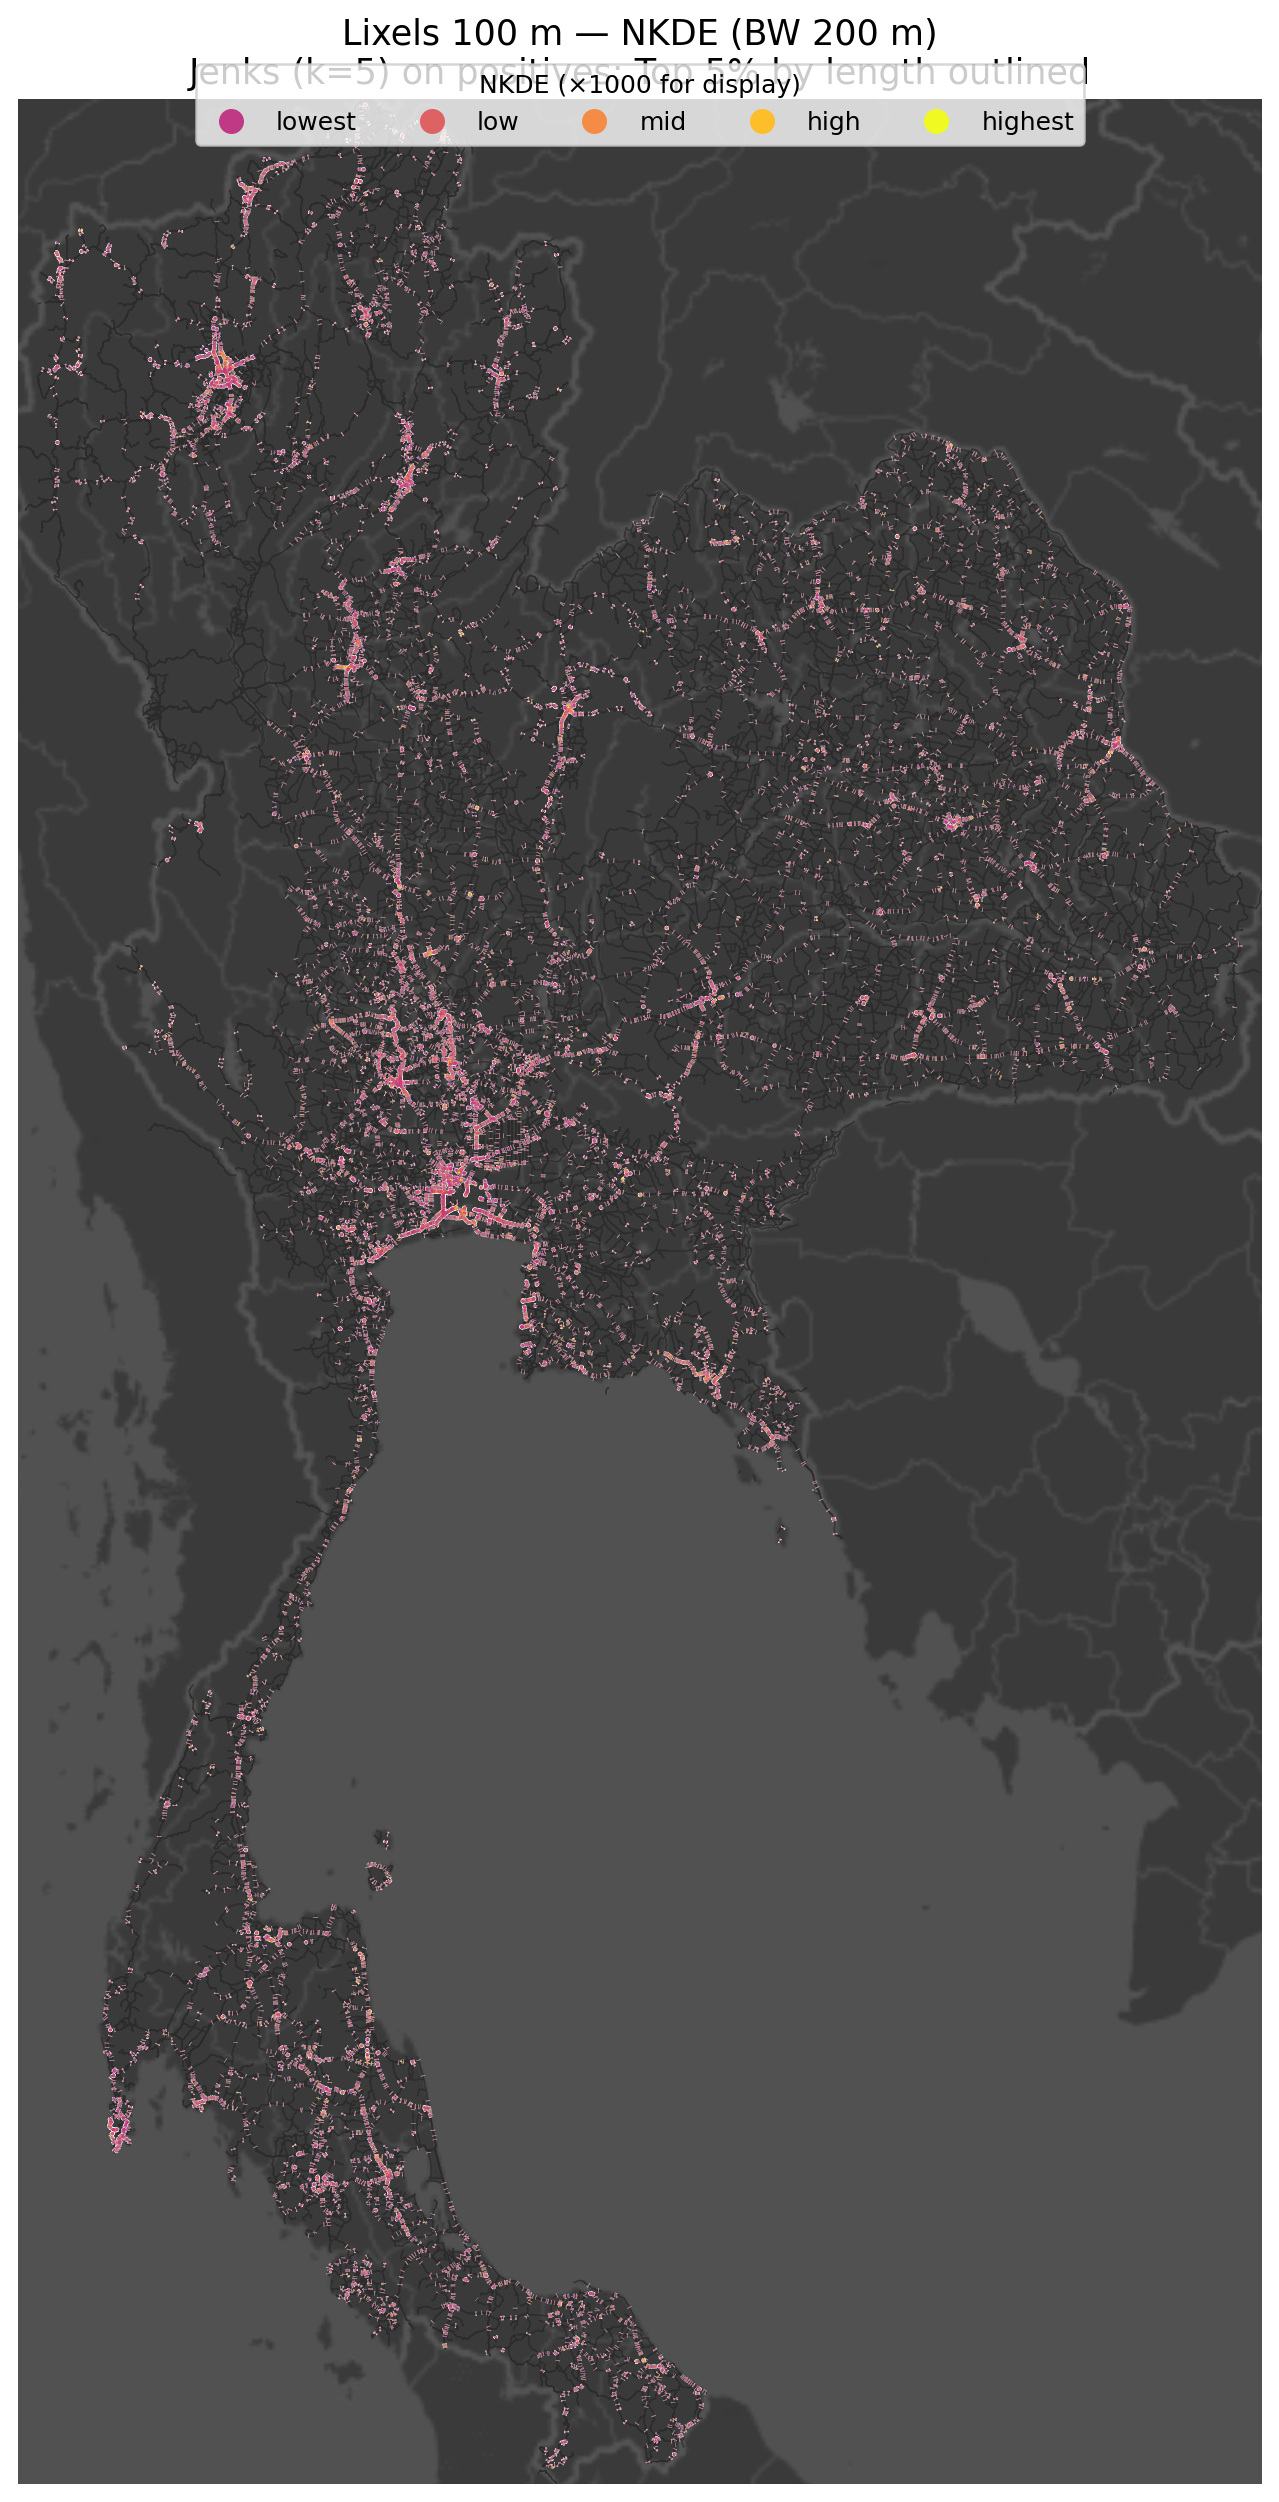

In [96]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import mapclassify
import contextily as ctx

# ----------------- config -----------------
dens_col = "density_bw200"   # NKDE column (BW = 200 m)
SCALE    = 1000.0            # multiply values for display/classing (set to 1.0 to use raw)
K        = 5                 # number of classes for positives (Jenks)
COVERAGE = 0.05              # highlight top 5% by cumulative length
tiles    = ctx.providers.CartoDB.DarkMatterNoLabels
# ------------------------------------------

# Load lixels (100 m) already in your session: lixels_100
g = lixels_100.copy().to_crs(epsg=3857)

# ensure numeric & prep
g[dens_col] = pd.to_numeric(g[dens_col], errors="coerce")
g["len_m"]  = g.geometry.length
g["val"]    = g[dens_col] * SCALE  # purely for visibility/classing

# split zeros / positives
g_zero = g[g["val"].fillna(0) <= 0]
g_pos  = g[g["val"].fillna(0) > 0].copy()

# ----- Jenks (Natural Breaks) on positives; fallback to quantiles if needed -----
if not g_pos.empty and g_pos["val"].nunique() > K:
    jenks = mapclassify.NaturalBreaks(g_pos["val"], k=K)
else:
    jenks = mapclassify.Quantiles(g_pos["val"], k=K)
bins = jenks.bins.tolist()  # K upper bounds

# class labels for legend
labels = ["lowest", "low", "mid", "high", "highest"][:K]
pos_colors = [plt.cm.plasma(x) for x in np.linspace(0.45, 1.0, K)]  # pops on dark
cmap = ListedColormap(pos_colors)

# ----- compute top 5% by cumulative length (over the WHOLE network) -----
g_rank = g.sort_values("val", ascending=False).copy()
g_rank["cum_len"] = g_rank["len_m"].cumsum()
total_len = float(g_rank["len_m"].sum())
cut_len = COVERAGE * total_len
hot5 = g_rank[g_rank["cum_len"] <= cut_len]           # top 5% set (includes any zeros if they slip in)

# ----- plotting -----
fig, ax = plt.subplots(figsize=(11, 14), dpi=180)

# faint skeleton for zeros
if not g_zero.empty:
    g_zero.plot(ax=ax, color="#2b2b2b", linewidth=0.5, zorder=1)

# white halo to lift lines off the dark basemap
if not g_pos.empty:
    g_pos.plot(ax=ax, color="white", linewidth=1.8, alpha=0.95, zorder=2)

# coloured positives (5 Jenks classes)
g_pos.plot(
    ax=ax,
    column="val",
    scheme="UserDefined",
    classification_kwds={"bins": bins},
    cmap=cmap,
    linewidth=1.2,
    legend=True,
    legend_kwds={
        "title": f"NKDE (×{int(SCALE)} for display)" if SCALE != 1.0 else "NKDE",
        "labels": labels,
        "loc": "upper center",
        "bbox_to_anchor": (0.5, 1.02),
        "ncol": K
    },
    zorder=3
)

# top 5% overlay (thick, bright outline)
if not hot5.empty:
    hot5.plot(ax=ax, color="none", edgecolor="#00ffff", linewidth=2.6, zorder=4)

# dark basemap (slightly dimmed so lines pop)
ctx.add_basemap(ax, source=tiles, attribution=False, alpha=0.8, zorder=0)

# national extent (or zoom to positives if you prefer)
ax.set_xlim(*g.total_bounds[[0, 2]])
ax.set_ylim(*g.total_bounds[[1, 3]])
ax.set_axis_off()
ax.set_title("Lixels 100 m — NKDE (BW 200 m)\nJenks (k=5) on positives; Top 5% by length outlined", fontsize=14)
plt.tight_layout()
plt.show()


In [2]:
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties

# ---------- helpers ----------
def _nice_length_m(data_width_m):
    """Pick a nice scalebar length (1/2/5 × 10^n) ~ 1/5 of axis width."""
    target = data_width_m / 5.0
    import math
    exp = int(math.floor(math.log10(target))) if target > 0 else 0
    base = target / (10 ** exp)
    for b in (1, 2, 5, 10):
        if base <= b:
            return b * (10 ** exp)
    return 10 * (10 ** exp)

def add_scalebar(ax, loc="lower left", font_size=9, pad=0.2):
    """Add a scalebar (meters) to an EPSG:3857 axis."""
    xmin, xmax = ax.get_xlim()
    length_m = _nice_length_m(xmax - xmin)
    label = f"{int(length_m/1000)} km" if length_m >= 1000 else f"{int(length_m)} m"
    fp = FontProperties(size=font_size)
    sb = AnchoredSizeBar(ax.transData, length_m, label, loc,
                         pad=pad, color='black', frameon=True,
                         size_vertical=(xmax - xmin) * 0.003,
                         fontproperties=fp)
    ax.add_artist(sb)

def add_north_arrow(ax, xy=(0.8, 0.82), size=0.08, text="N", text_size=10):
    """Add a simple north arrow in axes fraction coords."""
    ax.annotate("", xy=(xy[0], xy[1] + size), xytext=xy,
                xycoords="axes fraction", textcoords="axes fraction",
                arrowprops=dict(arrowstyle="-|>", linewidth=1.5, color="black"))
    ax.text(xy[0], xy[1] + size + 0.015, text,
            transform=ax.transAxes, ha="center", va="bottom",
            fontsize=text_size, fontweight="bold")

In [5]:
lixels_100 = gpd.read_file('/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/out/nkde_lixels_joined/lixels_with_density_lx100.gpkg')

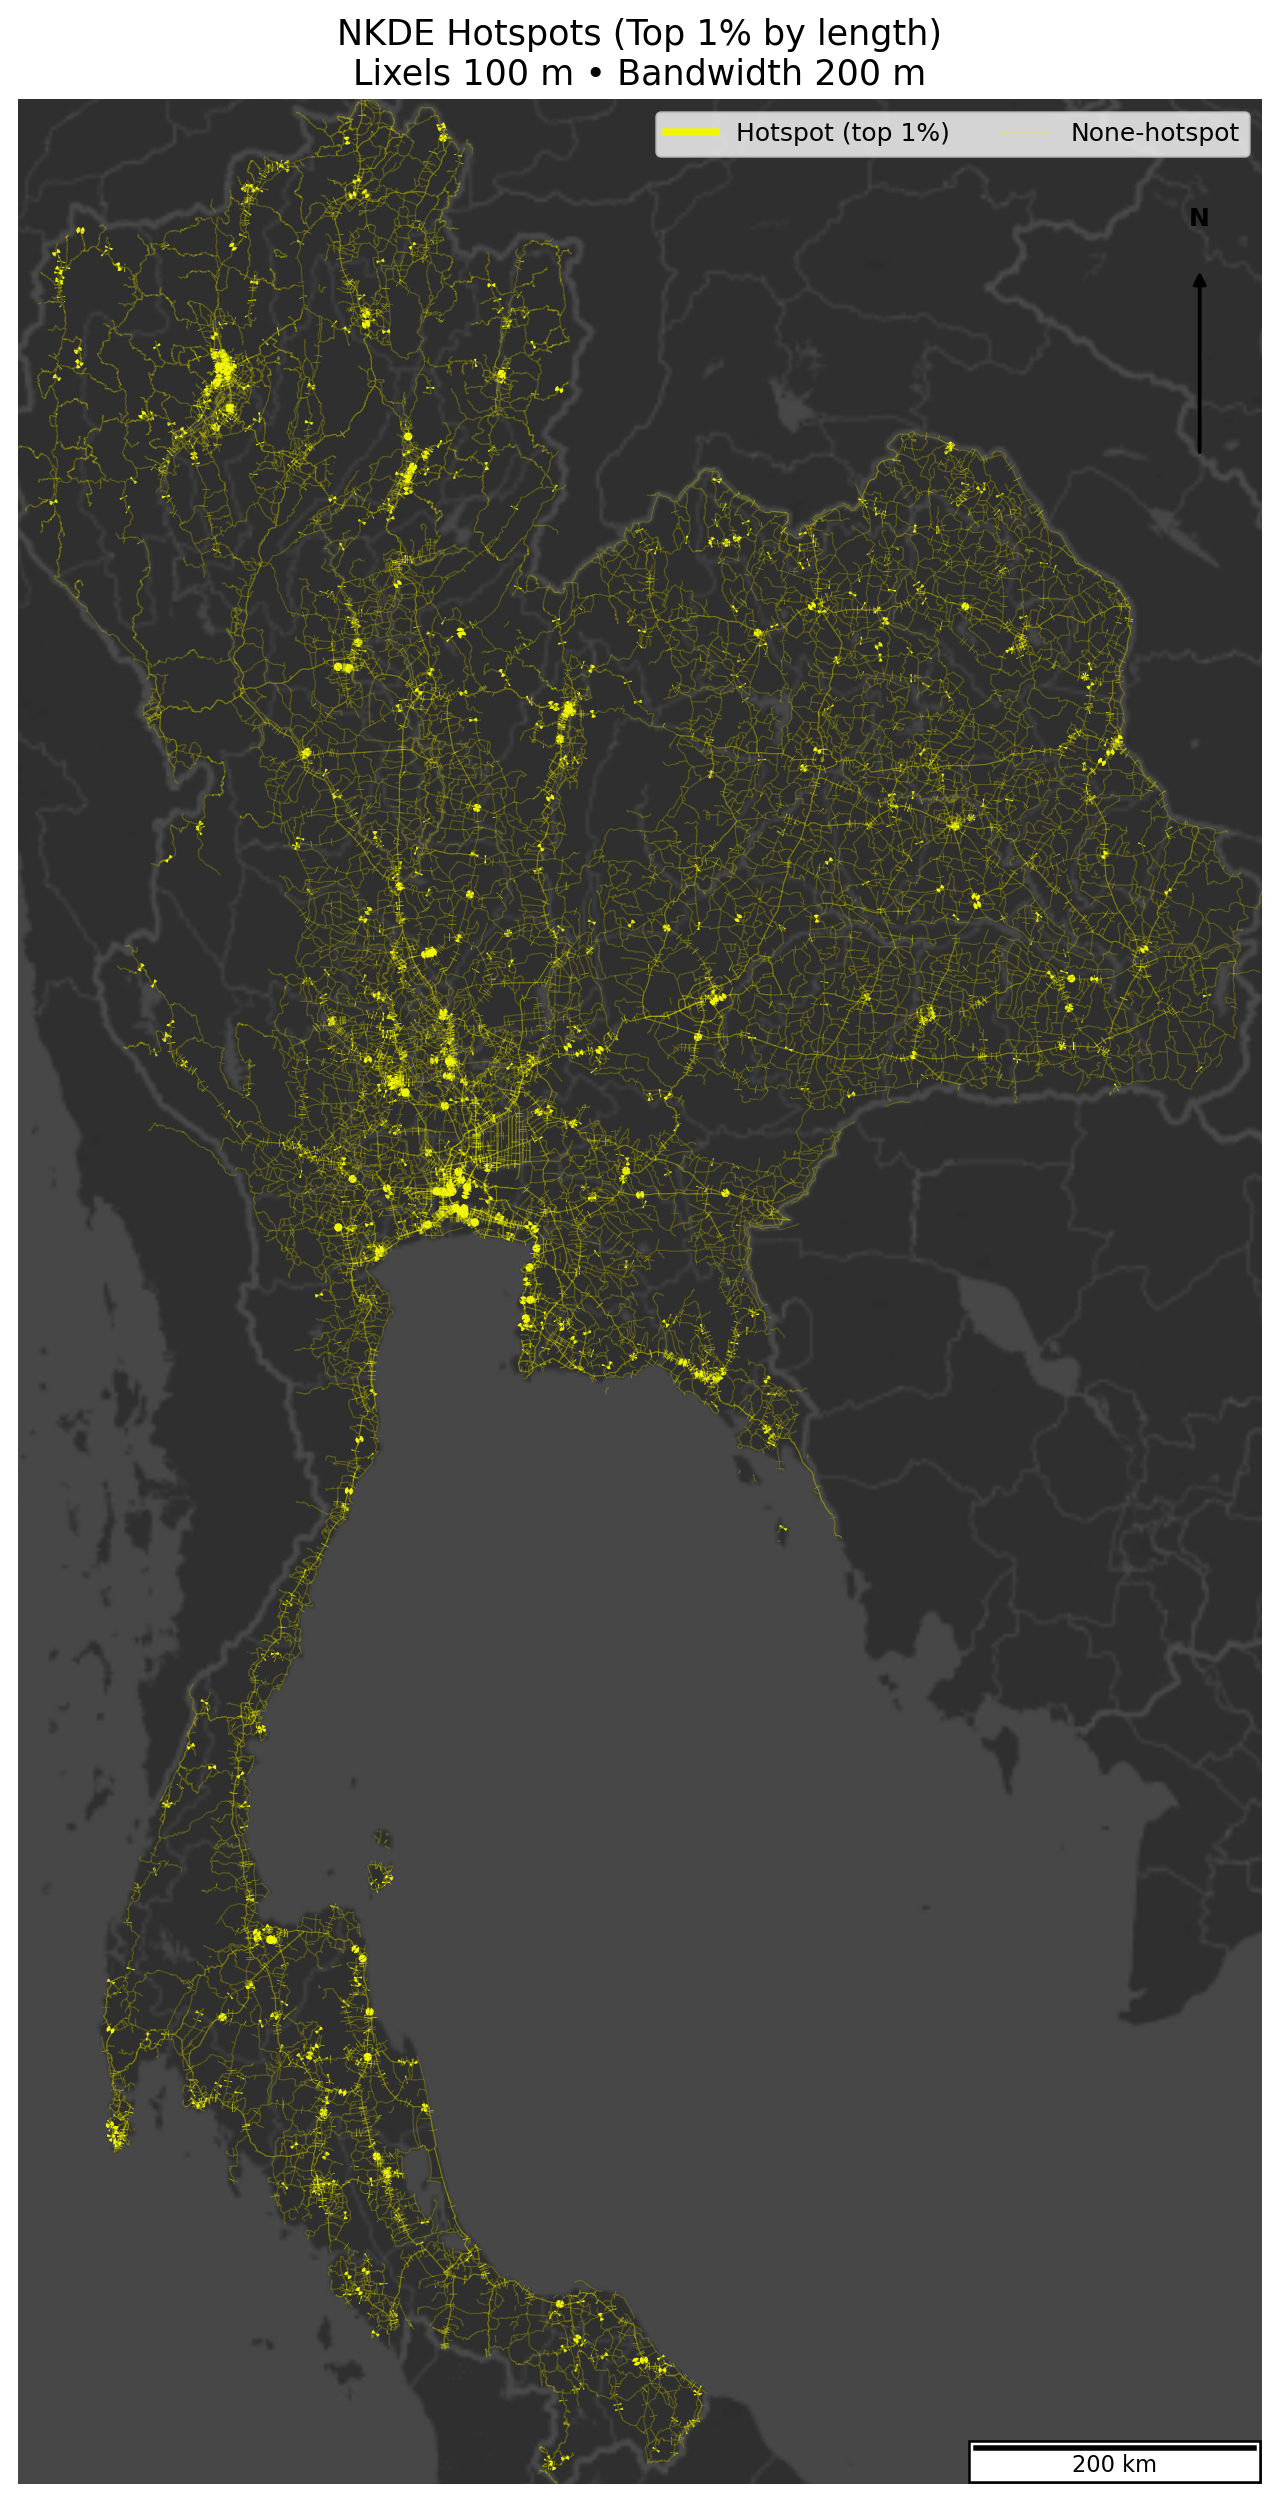

In [25]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D

# --- config ---
dens_col = "density_bw200"     # NKDE @ BW=200 m
COVERAGE = 0.01                # top 1% by cumulative length = hotspots
tiles    = ctx.providers.CartoDB.DarkMatterNoLabels

# --- data (assumes lixels_100 already loaded) ---
g = lixels_100.copy().to_crs(epsg=3857)
g[dens_col] = pd.to_numeric(g[dens_col], errors="coerce")
g["len_m"]  = g.geometry.length

# rank by density (desc), accumulate length, select top 5%
g_rank = g.sort_values(dens_col, ascending=False).copy()
g_rank["cum_len"] = g_rank["len_m"].cumsum()
total_len = float(g_rank["len_m"].sum())
cut_len   = COVERAGE * total_len

hot_idx = g_rank.index[g_rank["cum_len"] <= cut_len]
g["is_hot"] = g.index.isin(hot_idx)

hot  = g[g["is_hot"]]
rest = g[~g["is_hot"]]

# --- plot (two colors only) ---
fig, ax = plt.subplots(figsize=(11, 14), dpi=180)

# non-hotspots (thin, dark grey)
if not rest.empty:
    rest.plot(ax=ax, color="#efef0640", linewidth=0.5, zorder=2)

# hotspots (thicker, bright)
if not hot.empty:
    hot.plot(ax=ax, color="#f1f506", linewidth=3.2, zorder=3)  # try 2.8–3.2 if still too thin

# dark basemap
ctx.add_basemap(ax, source=tiles, attribution=False, alpha=0.85, zorder=1)

# view + styling
ax.set_xlim(*g.total_bounds[[0, 2]])
ax.set_ylim(*g.total_bounds[[1, 3]])
ax.set_axis_off()
ax.set_title("NKDE Hotspots (Top 1% by length)\nLixels 100 m • Bandwidth 200 m", fontsize=14)

# scale + north arrow
add_scalebar(ax, loc="lower right")
add_north_arrow(ax, xy=(0.95, 0.85), size=0.08)

# simple legend (two categories)
handles = [
    Line2D([0],[0], color="#f1f506", lw=3, label="Hotspot (top 1%)"),
    Line2D([0],[0], color="#efef0640", lw=1.2, label="None-hotspot")
]
ax.legend(handles=handles, loc="upper right", ncol=2, frameon=True)

plt.tight_layout()
plt.show()


In [29]:
#save the g
g.to_file("roadnetwork/hotspot_top1.gpkg", layer="lixels100_bw200", driver="GPKG")

In [ ]:
print("min density hotspot", g[g['is_hot']==True]["density_bw200"].min(),"max density hotspot" ,g[g['is_hot']==True]["density_bw200"].max())
print("min density non-hotspot", g[g['is_hot']==False]["density_bw200"].min(),"max density non-hotspot", g[g['is_hot']==False]["density_bw200"].max())

min density hotspot 0.00014869392808291242 max density hotspot 0.0027384989638973107
min density non-hotspot 0.0 max density non-hotspot 0.00014869188055697372
